In [7]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn

print(torch.__version__)

notebook_dir = os.getcwd()
model_b_root = os.path.abspath(os.path.join(notebook_dir, "../"))
project_root = os.path.abspath(os.path.join(notebook_dir, "../../.."))

if project_root not in sys.path:
    sys.path.append(project_root)
    
if model_b_root not in sys.path:
    sys.path.append(model_b_root)


2.2.2


## Create test set with full data

In [8]:
from torch.utils.data import DataLoader
from custom_dataset import SepsisPatientDataset, collate_fn
from testing import testing_loop

df = pd.read_parquet(f"{project_root}/dataset/preprocessed_data.parquet")

# Create dataset without splitting
test_dataset = SepsisPatientDataset(
    data=df.drop(columns=["SepsisLabel", "patient_id"]).values,
    labels=df["SepsisLabel"].values,
    patient_ids=df["patient_id"].values,
    time_index=df.columns.get_loc("ICULOS")
)

# Create dataloader with appropriate batch size
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)


## Load experiment

In [9]:
import yaml
from pprint import pprint

experiment_name = "09_time_series_transformer"

# from results folder load the yml file called xperiment.yml
xperiment_path = f"{model_b_root}/results/{experiment_name}/xperiment.yml"
with open(xperiment_path, 'r') as file:
    xperiment = yaml.safe_load(file)

pprint(xperiment)

{'data': {'data_file_name': 'preprocessed_data',
          'random_state': 42,
          'sampling': True,
          'sampling_method': 'undersample',
          'sampling_minority_ratio': 0.3,
          'test_size': 0.2,
          'train_sample_fraction': 0.3,
          'use_last_processed_data': False},
 'model': {'d_model': 128,
           'drop_out': 0.2,
           'input_dimention': 61,
           'num_heads': 4,
           'num_layers': 2},
 'testing': {'batch_size': 32},
 'training': {'batch_size': 32,
              'epochs': 100,
              'lr': 0.001,
              'max_post_weight': 5,
              'post_weight': 2.3299999237060547,
              'use_post_weight': True,
              'weight': 2.33},
 'xperiment': {'model': 'time_series', 'name': '09_time_series_transformer'}}


In [13]:
from architectures import TransformerTimeSeries

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = test_dataset.data.shape[1]

model = TransformerTimeSeries(
    input_dim=input_dim,
    d_model=xperiment["model"]["d_model"],
    n_heads=xperiment["model"]["num_heads"],
    n_layers=xperiment["model"]["num_layers"],
    dropout=xperiment["model"]["drop_out"]
)

pos_weight_tensor = torch.tensor(xperiment["training"]["post_weight"], device=device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

all_y_logits, all_y_probs, all_y_pred, all_y_test = testing_loop(
    model=model,
    test_loader=test_loader,
    device=device,
    loss_fn=loss_fn,
    threshold=0.5
)

/Users/damianstone/Documents/Code/machine-learning/dl-sepsis-prediction/venv-sepsis/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
                                                                                   

Test Loss: 0.80824 | Test Accuracy: 0.47%


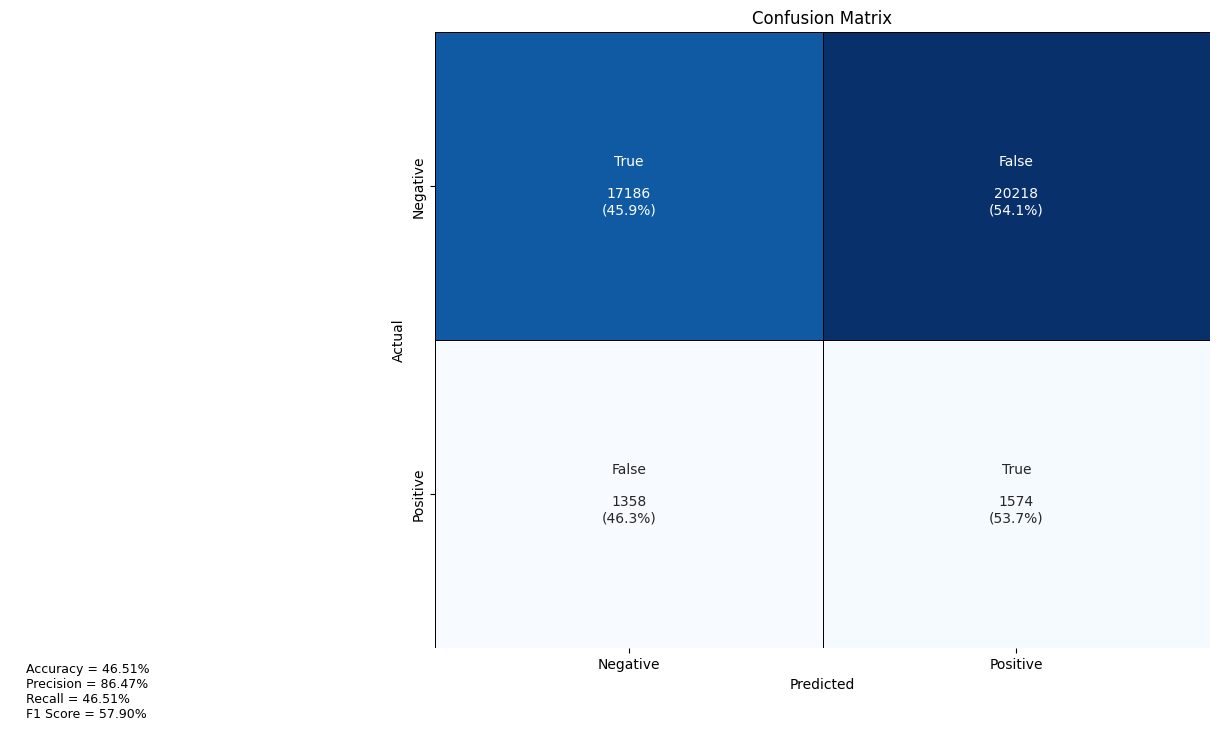

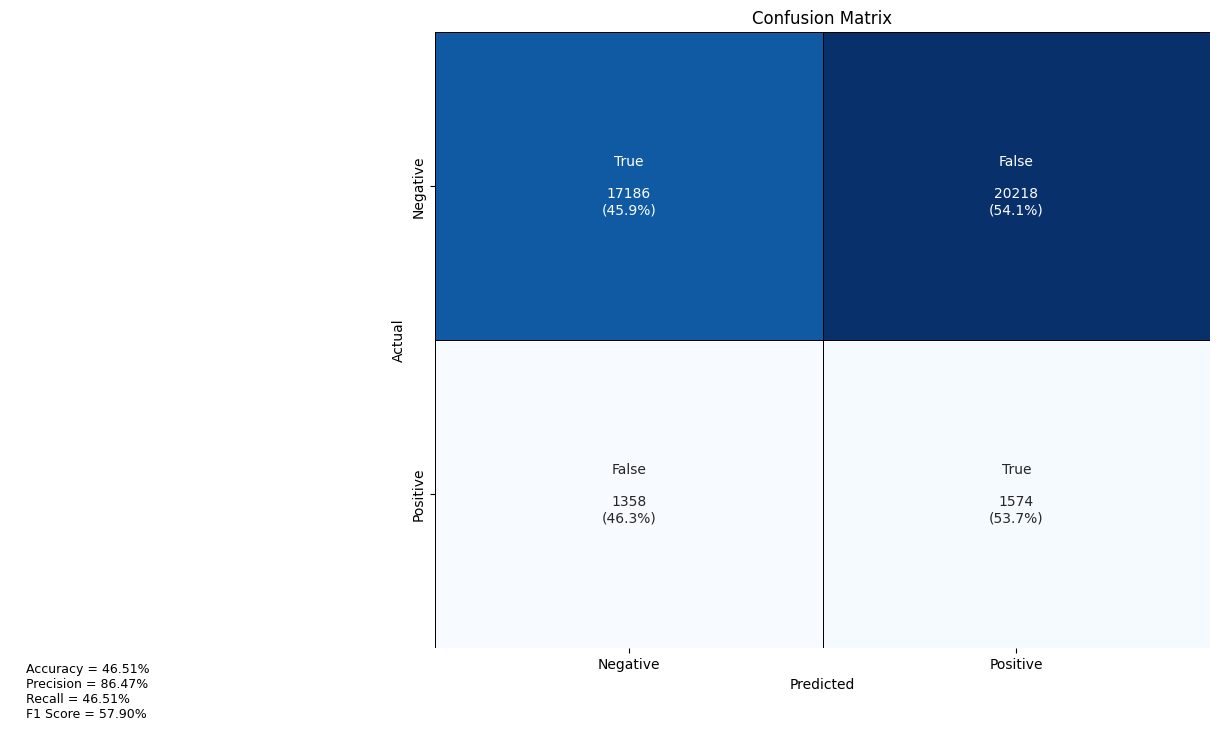

In [19]:
from model_utils.plots import plot_confusion_matrix
import torch

# Concatenate all tensors in the lists first
y_test_np = torch.cat(all_y_test).cpu().numpy()
y_pred_np = torch.cat(all_y_pred).cpu().numpy()

plot_confusion_matrix(y_test_np, y_pred_np)